# Variance-based Nystrom randomized svd method
Constructs low rank eigenvalue decomposition of a symmetric matrix that is the average of many other symmetric matrices.

The conventional Nystrom method is explained in of Halko, Martinsson, Tropp, Page 32, Algorithm 5.3

Unlike the conventional method, which truncates based on size of the eigenvalues, here we truncated based on the relative variance of the Rayleigh quotients in eigenvector directions.

In [1]:
import numpy as np
import sys
sys.path.append('../hessianlearn/algorithms/')
from varianceBasedNystrom import *
import matplotlib.pyplot as plt

In [2]:
n = 500
m = 50
p = 7
batch_r = 10
randomness_factor = 0.1

# Make random symmetric matrices
$$A = \frac{1}{m}\left(A_1 + A_2 + \dots + A_m\right)$$

In [3]:
def make_random_symmetric_matrix():
    U, _ = np.linalg.qr(np.random.randn(n,n))
    ss = np.random.randn(n)**p
    A = np.dot(U, np.dot(np.diag(ss), U.T))
    return A

In [4]:
A0 = make_random_symmetric_matrix()
AA = [A0 + randomness_factor * make_random_symmetric_matrix() for _ in range(m)]
    
apply_AA = [lambda x, Ak=Ak: np.dot(Ak,x) for Ak in AA]

A = np.sum(AA, axis=0)/m

In [5]:
x = np.random.randn(n)
np.linalg.norm(apply_AA[2](x) - np.dot(AA[2],x))

0.0

In [6]:
np.linalg.norm(AA[0] - A0)/np.linalg.norm(A0)

0.0875297176588406

err_A_sym= 1.6243725619083162e-16


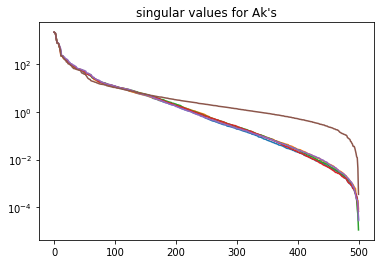

In [7]:
err_A_sym = np.linalg.norm(A - A.T)/np.linalg.norm(A)
print('err_A_sym=', err_A_sym)

plt.figure()
for k in range(5):
    _,ss,_ = np.linalg.svd(AA[k])
    plt.semilogy(ss)
plt.title('singular values for Ak\'s')

_,ss,_ = np.linalg.svd(A)
plt.semilogy(ss)

# Get approximate orthogonal basis for range
$$\Omega = \text{random }n \times r\text{ matrix}$$
$$Y = A \Omega$$ 
$$QR = Y$$

In [8]:
Y = get_random_range_vectors(apply_AA, n, batch_r)

In [9]:
Q,_ = np.linalg.qr(Y)

In [10]:
range_err = np.linalg.norm(A - np.dot(Q, np.dot(Q.T, A)))/np.linalg.norm(A)
print('range_err=', range_err)

range_err= 0.3648051266082635


# Construct Theta tensor
$$\Theta_{ijk} = q_i^T A_k q_j$$
I.e.,
$$\Theta_{::k} = Q^T A_k Q$$

$$A \approx Q(Q^T A Q)Q^T$$
$$Q^T A Q = V D V^T$$
$$A = U D U^T$$
$$U = QV$$
$$Q^T A Q = \sum_k \Theta_{ijk}$$

In [11]:
Theta = compute_Theta(Q, apply_AA)

In [12]:
def compute_Theta_slow(Q, apply_AA):
    r = Q.shape[1]
    m = len(apply_AA)
    Theta_true = np.zeros((r, r, m))
    for i in range(r):
        for j in range(r):
            for k in range(m):
                Theta_true[i,j,k] = np.dot(Q[:,i], apply_AA[k](Q[:,j]))
    return Theta_true

In [13]:
Theta_true = compute_Theta_slow(Q, apply_AA)
err_Theta = np.linalg.norm(Theta - Theta_true)/np.linalg.norm(Theta_true)
print('err_Theta=', err_Theta)

err_Theta= 2.143422950799156e-16


# Construct eigenvalue decomposition
$$A \approx U D U^T$$
where $D$ is the diagonal matrix with diagonal dd.

In [14]:
dd, U, V = finish_computing_eigenvalue_decomposition(Q, Theta)

In [15]:
A_approx = np.dot(U, np.dot(np.diag(dd), U.T))
err_A = np.linalg.norm(A - A_approx)/np.linalg.norm(A)
print('err_A=', err_A)

err_A= 0.45788536276688374


# Compute mean and variance of Rayleigh quotients
$$\mu_i = \mathbb{E}_{A_k}\left[ u_i^T A_k u_i\right]$$
$$\sigma_i^2 = \mathbb{E}_{A_k}\left[ \left(u_i^T A_k u_i - \mu_i\right)^2\right]$$
where
$$U = \begin{bmatrix}
u_1 & u_2 & \dots & u_r
\end{bmatrix}$$
$$A = Q V D V^T Q^T$$
$$u_i = Q v_i$$
$$V = \begin{bmatrix}
v_1 & v_2 & \dots v_r
\end{bmatrix}$$
$$u_i^T A_k u_i = (Qv_i)^T A_k (Qv_i) = v_i^T (Q^T A_k Q) v_i$$

In [16]:
all_mu, all_std = compute_rayleigh_statistics(Theta, V)

In [17]:
def compute_rayleigh_statistics_slow(U, apply_AA):
    m = len(apply_AA)
    r = U.shape[1]
    C = np.zeros((r, m))
    for k in range(m):
        for i in range(r):
            C[i,k] = np.dot(U[:,i], apply_AA[k](U[:,i]))

    all_mu = np.mean(C, axis=1)
    all_std = np.std(C, axis=1)
    return all_mu, all_std

In [18]:
all_mu_true, all_std_true = compute_rayleigh_statistics_slow(U, apply_AA)

err_mu = np.linalg.norm(all_mu - all_mu_true)/np.linalg.norm(all_mu_true)
err_std = np.linalg.norm(all_std - all_std_true)/np.linalg.norm(all_std_true)

print('err_mu=', err_mu)
print('err_std=', err_std)

err_mu= 9.030648095072285e-17
err_std= 8.821315206196506e-15


# Get more vectors for better range approximation
$$Q_\text{new} = \begin{bmatrix}Q & Q_2\end{bmatrix}$$

In [19]:
Y2 = get_random_range_vectors(apply_AA, n, batch_r)
Y2_perp = Y2 - np.dot(Q,np.dot(Q.T, Y2))
Q2,_ = np.linalg.qr(Y2_perp)
Q_new = np.hstack([Q, Q2])

In [20]:
err_Q_orth = np.linalg.norm(np.dot(Q_new.T, Q_new) - np.eye(Q_new.shape[1]))
print('err_Q_orth=', err_Q_orth)

err_Q_orth= 5.202931864871794e-15


# Redo computations with better range approximation

$$\Theta_{::k} = \begin{bmatrix}
\Theta^{(11)}_{::k} & \Theta^{(12)}_{::k} \\
\Theta^{(21)}_{::k} & \Theta^{(22)}_{::k} 
\end{bmatrix}$$

In [21]:
Theta_new = update_Theta(Q, Q2, Theta, apply_AA)

In [22]:
Theta_true_new = compute_Theta_slow(Q_new, apply_AA)

err_Theta_new = np.linalg.norm(Theta_new - Theta_true_new)/np.linalg.norm(Theta_true_new)
print('err_Theta_new=', err_Theta_new)

err_Theta_new= 2.20249494741147e-16


In [23]:
dd_new, U_new, V_new = finish_computing_eigenvalue_decomposition(Q_new, Theta_new)

In [24]:
A_approx_new = np.dot(U_new, np.dot(np.diag(dd_new), U_new.T))
err_A_new = np.linalg.norm(A - A_approx_new)/np.linalg.norm(A)
print('err_A_new=', err_A_new)

err_A_new= 0.24150317157168258


In [25]:
all_mu_new, all_std_new = compute_rayleigh_statistics(Theta_new, V_new)

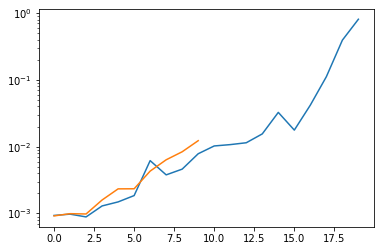

In [26]:
plt.semilogy(all_std_new/np.abs(dd_new))
plt.semilogy(all_std/np.abs(dd))

# Run the complete method from scratch

In [27]:
dd_good, U_good, all_std_good = variance_based_nystrom(apply_AA, n)

current_rank= 5 , num_bad_vectors= 0
current_rank= 15 , num_bad_vectors= 0
current_rank= 25 , num_bad_vectors= 0
current_rank= 35 , num_bad_vectors= 0
current_rank= 43 , num_bad_vectors= 2
current_rank= 50 , num_bad_vectors= 5


err_A_good= 0.07148963680617475


Text(0.5, 1.0, 'sigma/lambda')

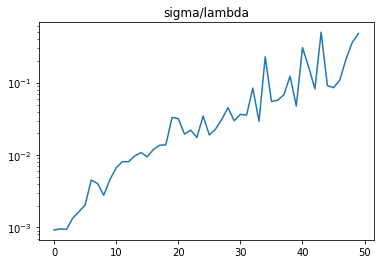

In [28]:
A_good_approx = np.dot(U_good, np.dot(np.diag(dd_good), U_good.T))
err_A_good = np.linalg.norm(A_good_approx - A)/np.linalg.norm(A)
print('err_A_good=', err_A_good)
plt.semilogy(all_std_good/np.abs(dd_good))
plt.title('sigma/lambda')

In [29]:
print(dd_good.shape)
print(U_good.shape)

(50,)
(500, 50)
